# Linear mixed effects model (LME)
## Random intercept only

In [1]:
%load_ext autoreload
%autoreload 2
    
import pandas as pd
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 500)

import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
print(pm.__version__)
import theano.tensor as tt
import patsy

/Users/Alberto/miniconda3/envs/bayestest/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


3.4.1


In [2]:
plt.style.use('seaborn-darkgrid')

In [3]:
SEED = 123
DRAWS = 2000
BURNIN = 2000
TUNE = 1000
CHAINS = 4
CORES = 2

# Reaction Times In A Sleep Deprivation Study
The dataset contains the average reaction time per day for subjects in a sleep deprivation study. On day 0 the subjects had their normal amount of sleep. Starting that night they were restricted to 3 hours of sleep per night. The observations represent the average reaction time on a series of tests given each day to each subject. Data from: https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/lme4/sleepstudy.csv

### Data loading

In [4]:
sleep = pd.read_csv('../datasets/sleepstudy.csv', index_col=0)
sleep['Subject'] = pd.Categorical(sleep['Subject'], ordered=False)
sleep.head()

,Reaction,Days,Subject
1,249.5600,0,308
2,258.7047,1,308
3,250.8006,2,308
4,321.4398,3,308
5,356.8519,4,308


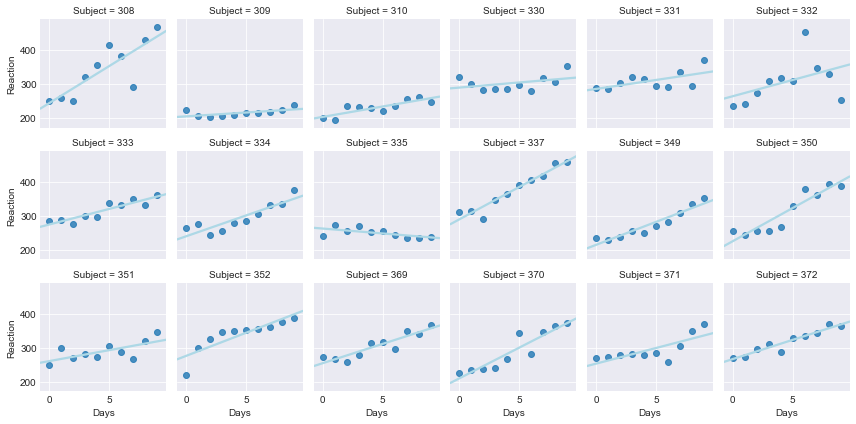

In [5]:
sns.lmplot(x="Days", y="Reaction", col="Subject", data=sleep, col_wrap=6, palette="muted", aspect=1, size=2, ci=None, line_kws={'color':'lightblue'});

## Modelling

Design matrix for the fixed effect (population effect)

In [6]:
X = patsy.dmatrix("1 + Days", data=sleep, return_type='dataframe')
X = np.asarray(X)
X[:10,:]

array([[1., 0.],
       [1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.],
       [1., 5.],
       [1., 6.],
       [1., 7.],
       [1., 8.],
       [1., 9.]])

Design matrix for the random effect (intercept only). This means that each subject will deviate from the average intercept by some amount, but the slope will be the same across participants

In [7]:
Z = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
Z = np.asarray(Z)
Z

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [8]:
Y = np.asarray(sleep['Reaction'])
Y.mean()

298.50789166666664

In [9]:
with pm.Model() as model_intercept:
    beta_X_intercept = pm.HalfNormal('beta_X_intercept', sd=10000) # Intercept is constrained to be positive because reaction time can only be positive
    #beta_X_intercept = pm.Bound(pm.Normal, lower=0.0)('beta_X_intercept', mu=Y.mean(), sd=100)
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X = tt.stack(beta_X_intercept, beta_X_slope)
    
    # Multiply the betas coefficient with the design matrix X
    estimate_X = pm.math.dot(X, beta_X)

    # Non Centered version
    # The idea behind the non-centered version is to make sampling easier by sampling on probability distributions with the similar dimension. 
    # For example if the sampler is tune on a Normal (0, 1), it will have worse performance in sampling tiny values because the leap frog jump will be to long.
    # Hence, we sample the gamma_raw value and a scaler independently. Normal(0, 30) is the same as N(0, 1) * 30
    gamma_Z_sd = pm.HalfNormal('gamma_Z_sd', sd=100) # This acts like a scaler. The scaler is quite wide since the intercept value can vary quite much around the average value of 300 ms.

    gamma_Z_raw = pm.Normal('gamma_Z_raw', mu=0, sd=1, shape=Z.shape[1])
    gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_raw * gamma_Z_sd)
    
    # Multiply the gammas coefficient with the design matrix Z
    estimate_Z = pm.math.dot(Z, gamma_Z)
    
    # likelihood
    estimate = estimate_X + estimate_Z
    sigma_unexplained = pm.HalfNormal('sigma_unexplained', sd=100) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=estimate, sd=sigma_unexplained, observed=Y)
    
    trace_intercept = pm.sample(draws=DRAWS+BURNIN, chains=CHAINS, cores=CORES, tune=TUNE, random_seed=SEED, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma_unexplained, gamma_Z_raw, gamma_Z_sd, beta_X_slope, beta_X_intercept]
100%|██████████| 5000/5000 [03:10<00:00, 26.30it/s]
The number of effective samples is smaller than 25% for some parameters.


In [10]:
trace_intercept = trace_intercept[BURNIN: ]

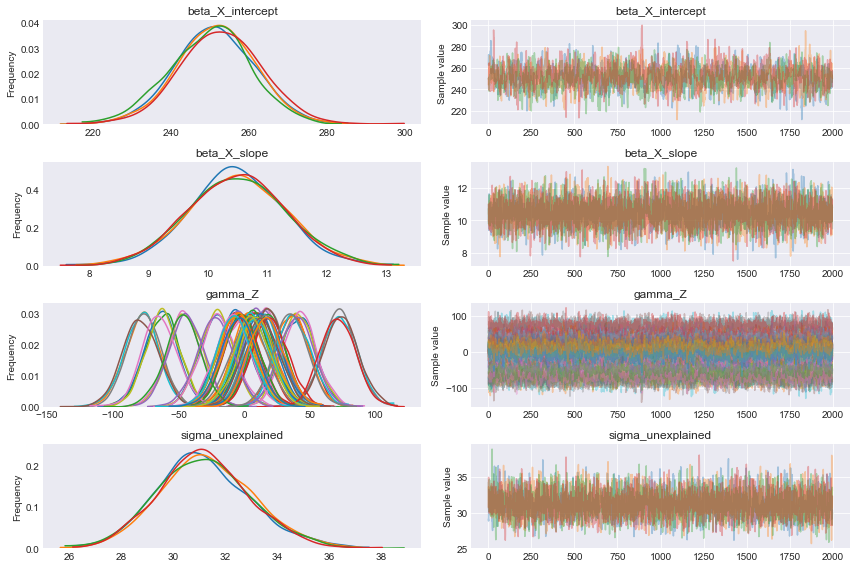

In [11]:
_ = pm.traceplot(trace_intercept, varnames=['beta_X_intercept', 'beta_X_slope', 'gamma_Z', 'sigma_unexplained'])

In [12]:
pm.summary(trace_intercept)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_X_slope,10.476383,0.808436,0.010264,8.933231,12.125632,5644.470818,0.999926
gamma_Z_raw__0,1.056991,0.376816,0.008426,0.364941,1.824961,1765.685830,1.003989
gamma_Z_raw__1,-2.014037,0.473908,0.012683,-2.938432,-1.095754,1314.126787,1.001714
gamma_Z_raw__2,-1.635366,0.430524,0.011124,-2.498361,-0.830441,1435.836719,1.001348
gamma_Z_raw__3,0.114265,0.338259,0.007452,-0.546552,0.782275,1936.660168,1.004019
gamma_Z_raw__4,0.261827,0.340353,0.007351,-0.395125,0.948771,1910.927384,1.003786
gamma_Z_raw__5,0.211672,0.336428,0.007668,-0.416704,0.888514,1744.574761,1.003682
gamma_Z_raw__6,0.430464,0.339010,0.007608,-0.200516,1.143194,1848.353024,1.002800
gamma_Z_raw__7,-0.072028,0.337019,0.007616,-0.738394,0.583452,1755.191820,1.003184
gamma_Z_raw__8,-1.176358,0.393607,0.009750,-1.931660,-0.400226,1593.228860,1.002053


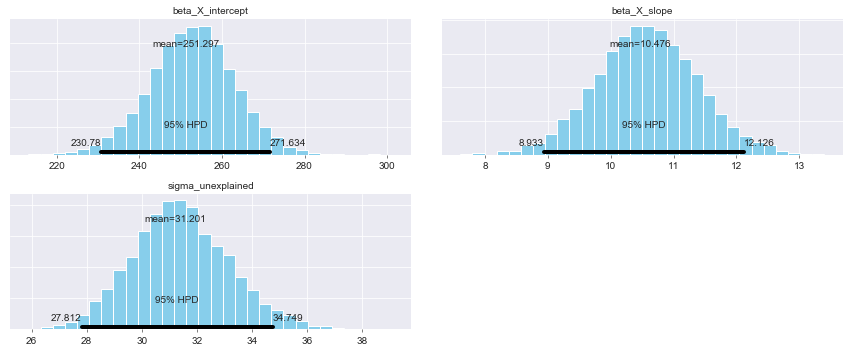

In [13]:
pm.plot_posterior(trace_intercept, varnames=['beta_X_intercept', 'beta_X_slope', 'sigma_unexplained']);

## Posterior predictive check

In [14]:
ppc = pm.sample_ppc(trace_intercept, samples=250, model=model_intercept)

100%|██████████| 250/250 [00:00<00:00, 542.16it/s]


In [15]:
def plot_ppc(sleep, ppc):
    days = np.unique(sleep.Days)
    subject_ids = np.unique(sleep.Subject)

    hpd = np.percentile(ppc['y_likelihood'], [2.5, 97.5], axis=0)

    fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
    ax = ax.ravel()

    for i, subject in enumerate(subject_ids):
        ax[i].plot(days, ppc['y_likelihood'].T[sleep.Subject==subject], 
                   marker='.', markersize=5, linestyle='none', alpha=0.8, color='lightblue')
        ax[i].plot(np.nan, np.nan, 
                   marker='.', markersize=5, linestyle='none', alpha=0.8, color='lightblue',
                   label='ppc')
        ax[i].fill_between(days, 
                           hpd[0, sleep.Subject==subject], hpd[1, sleep.Subject==subject],
                           step='mid', color='darkgray', alpha=0.8, label='95CI')

        ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values,
                   'o', label='observations')
        ax[i].set_title('Subj. {}'.format(subject))

    plt.legend() 

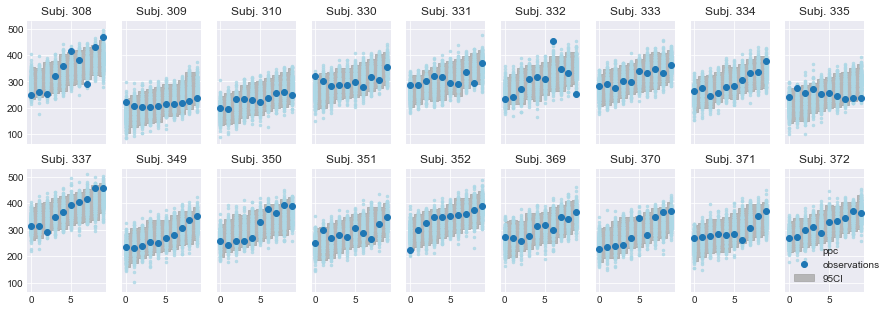

In [16]:
plot_ppc(sleep, ppc)

In [17]:
trace_df = pm.trace_to_dataframe(trace_intercept)

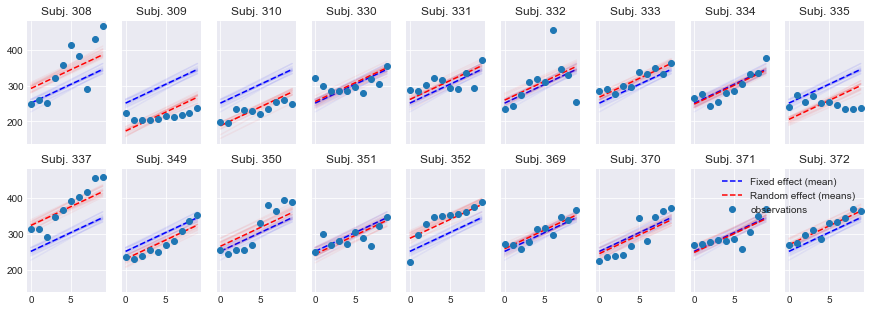

In [18]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    b0, b1 = trace_df['beta_X_intercept'][::500], trace_df['beta_X_slope'][::500]
    fit = b0[:, None] + days*b1[:, None]
    ax[i].plot(fit.T, '-b', alpha=0.05)
    ax[i].set_title('Subj. {}'.format(subject))
        
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, trace_df['beta_X_intercept'].mean() + days*trace_df['beta_X_slope'].mean(), '--b',
              label='Fixed effect (mean)')
    
# Random effect
for i, subject in enumerate(subject_ids):
    b0, b1, g0 = trace_df['beta_X_intercept'][::500], trace_df['beta_X_slope'][::500], trace_df['gamma_Z__{}'.format(i)][::500]
    fit = b0[:, None] + g0[:, None] + days*b1[:, None]
    ax[i].plot(fit.T, '-r', alpha=0.05)
        
        
for i, subject in enumerate(subject_ids):
    ax[i].plot(days,
               trace_df['beta_X_intercept'].mean() + trace_df['gamma_Z__{}'.format(i)].mean() + 
               days * trace_df['beta_X_slope'].mean(), '--r', 
               label='Random effect (means)')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o', label='observations')
    

plt.legend();


In [19]:
def plot_linear_pred_fixed_effect(trace_df, x, ax, thin=500, spaghetti=False):
    """Plot the linear model and 2sigma contours.
    http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/"""
    b0, b1 = trace_df['beta_X_intercept'][::thin], trace_df['beta_X_slope'][::thin]
    fit = b0[:, None] + x*b1[:, None]
    mu = fit.mean(0)
    
    if spaghetti:
        ax.plot(fit.T, '-b', alpha=0.05)
    else:
        sig = 2 * fit.std(0)
        ax.fill_between(x, mu - sig, mu + sig, color='blue', alpha=0.1)
        
    ax.plot(mu, '-b')

In [20]:
def plot_linear_pred_fixed_effect_matrix(trace_df, x, X, ax, thin=500, spaghetti=False):
    """Plot the linear model and 2sigma contours.
    http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/"""
    b0, b1 = trace_df['beta_X_intercept'][::thin], trace_df['beta_X_slope'][::thin]
    fit = np.dot(X, np.stack((b0, b1)))
    mu = fit.mean(1)
    
    if spaghetti:
        ax.plot(fit, '-b', alpha=0.05)
    else:
        sig = 2 * fit.std(1)
        ax.fill_between(x, mu - sig, mu + sig, color='blue', alpha=0.1)
        
    ax.plot(mu, '-b')


In [21]:
def plot_linear_pred_random_effect(trace_df, x, ax, thin=500, spaghetti=False):
    """Plot the linear model and 2sigma contours.
    http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/"""
    b0, b1, g0 = trace_df['beta_X_intercept'][::thin], trace_df['beta_X_slope'][::thin], trace_df['gamma_Z__{}'.format(i)][::thin]
    fit = b0[:, None] + g0[:, None] + days*b1[:, None]

    mu = fit.mean(0)
    
    if spaghetti:
        ax.plot(fit.T, '-r', alpha=0.05)
    else:
        sig = 2 * fit.std(0)
        ax.fill_between(x, mu - sig, mu + sig, color='r', alpha=0.1)
        
    ax.plot(mu, '-r')

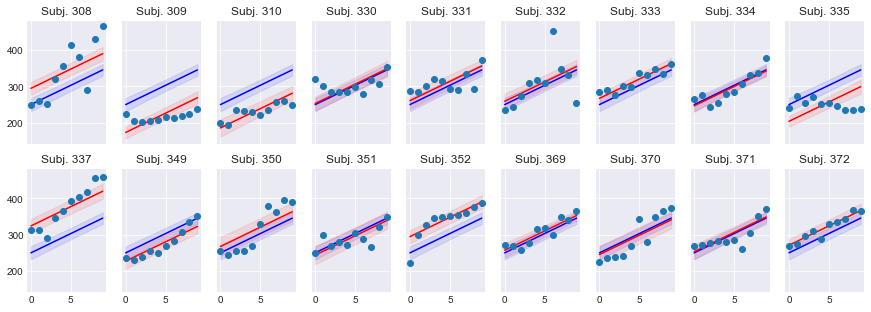

In [22]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    plot_linear_pred_fixed_effect(trace_df, days, ax[i])
    plot_linear_pred_random_effect(trace_df, days, ax[i])
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    ax[i].set_title('Subj. {}'.format(subject))

In [23]:
waic = pm.waic(trace_intercept, model_intercept, progressbar=True)
waic.WAIC

8000it [00:02, 3995.02it/s]
/Users/Alberto/miniconda3/envs/bayestest/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


1769.7522294497207

In [24]:
loo = pm.loo(trace_intercept, model_intercept)
loo.LOO

/Users/Alberto/miniconda3/envs/bayestest/lib/python3.6/site-packages/pymc3/stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


1770.423200233885

## Include second order coefficients

In [25]:
X = patsy.dmatrix("1 + Days + np.power(Days, 2)", data=sleep, return_type='dataframe')
X = np.asarray(X)
X[:10, :]

array([[ 1.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.],
       [ 1.,  5., 25.],
       [ 1.,  6., 36.],
       [ 1.,  7., 49.],
       [ 1.,  8., 64.],
       [ 1.,  9., 81.]])

In [26]:
Z = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
Z = np.asarray(Z)
Z

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [27]:
with pm.Model() as model_intercept_pow2:
    
    beta_X_intercept = pm.HalfNormal('beta_X_intercept', sd=10000) # Intercept is constrained to be positive because reaction time are positive only
    #beta_X_intercept = pm.Bound(pm.Normal, lower=0.0)('beta_X_intercept', mu=Y.mean(), sd=100)
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X_slope_pow2 = pm.Normal('beta_X_slope_pow2', mu=0, sd=100)

    beta_X = tt.stack(beta_X_intercept, beta_X_slope, beta_X_slope_pow2)
    
    estimate_X = pm.math.dot(X, beta_X)

    # Non Centered version
    # The idea behind the non-centered version is to make sampling easier by sampling on probability distributions with the similar dimension. 
    # For example if the sampler is tune on a Normal (0, 1), it will have worse performance in sampling tiny values because the leap frog jump will be to long.
    # Hence, we sample the gamma_raw value and a scaler independently. Normal(0, 30) is the same as N(0, 1) * 30
    gamma_Z_sd = pm.HalfNormal('gamma_Z_sd', sd=100) # # This acts like a scaler. The scaler is quite wide since the intercept value can vary quite much around the average value of 300 ms. 

    gamma_Z_raw = pm.Normal('gamma_Z_raw', mu=0, sd=1, shape=Z.shape[1])
    gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_raw * gamma_Z_sd)
    
    estimate_Z = pm.math.dot(Z, gamma_Z)
    
    ## likelihood
    estimate = estimate_X + estimate_Z
    sigma_unexplained = pm.HalfNormal('sigma_unexplained', sd=100) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=estimate, sd=sigma_unexplained, observed=Y)
    
    trace_intercept_pow2 = pm.sample(draws=DRAWS+BURNIN, chains=CHAINS, cores=CORES, tune=TUNE, random_seed=SEED, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma_unexplained, gamma_Z_raw, gamma_Z_sd, beta_X_slope_pow2, beta_X_slope, beta_X_intercept]
100%|██████████| 5000/5000 [18:04:39<00:00, 13.02s/it]  
The number of effective samples is smaller than 25% for some parameters.


In [28]:
trace_intercept_pow2 = trace_intercept_pow2[BURNIN: ]

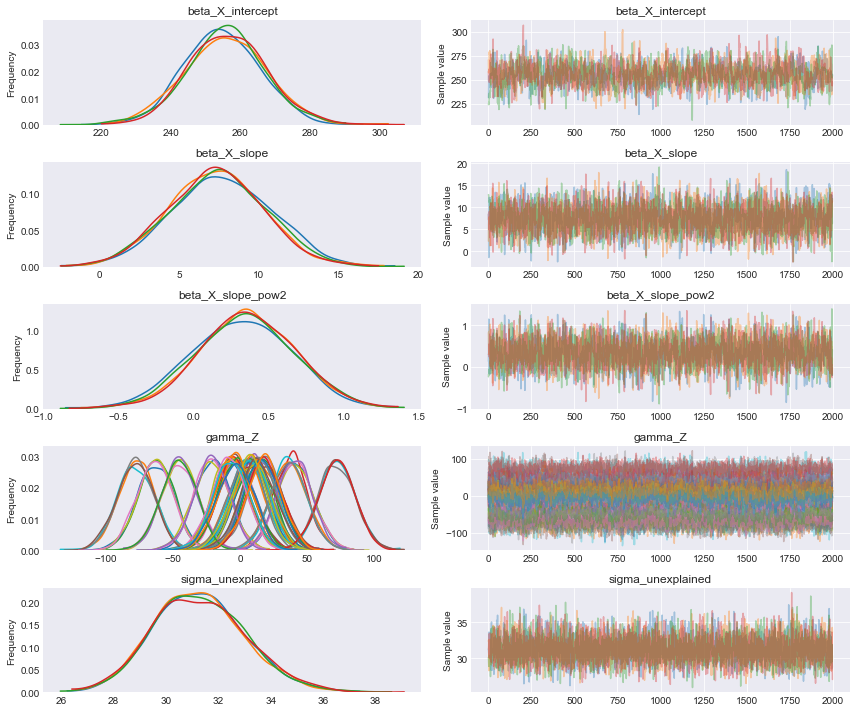

In [29]:
_ = pm.traceplot(trace_intercept_pow2, varnames=['beta_X_intercept', 'beta_X_slope', 'beta_X_slope_pow2', 'gamma_Z', 'sigma_unexplained'])

In [30]:
pm.summary(trace_intercept_pow2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_X_slope,7.417058,3.024007,0.056881,1.428177,13.150501,2759.230893,1.002015
beta_X_slope_pow2,0.340109,0.323504,0.005954,-0.266562,0.999884,2851.950381,1.001808
gamma_Z_raw__0,1.055149,0.383119,0.009698,0.317780,1.804508,1734.877168,1.000513
gamma_Z_raw__1,-2.016197,0.483889,0.011894,-3.006970,-1.141497,1562.086166,1.000910
gamma_Z_raw__2,-1.636151,0.436210,0.010403,-2.469543,-0.779451,1587.823849,1.000753
gamma_Z_raw__3,0.119218,0.343782,0.008323,-0.539812,0.807726,1835.801487,1.000262
gamma_Z_raw__4,0.263081,0.343082,0.008469,-0.381858,0.948999,1759.983683,1.000257
gamma_Z_raw__5,0.216491,0.341958,0.008268,-0.462180,0.857145,1647.731564,1.000825
gamma_Z_raw__6,0.424473,0.339972,0.008732,-0.247739,1.068892,1667.540673,1.000680
gamma_Z_raw__7,-0.078075,0.338468,0.008265,-0.755310,0.567672,1735.997217,1.000561


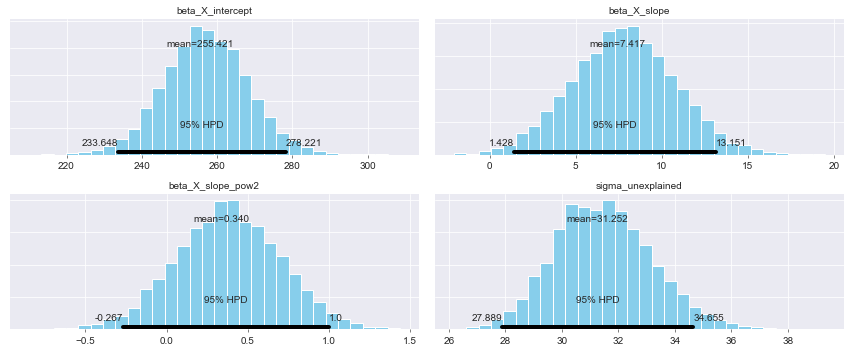

In [31]:
pm.plot_posterior(trace_intercept_pow2, varnames=['beta_X_intercept', 'beta_X_slope',  'beta_X_slope_pow2', 'sigma_unexplained']);

## Posterior predictive check

In [32]:
trace_df = pm.trace_to_dataframe(trace_intercept_pow2)

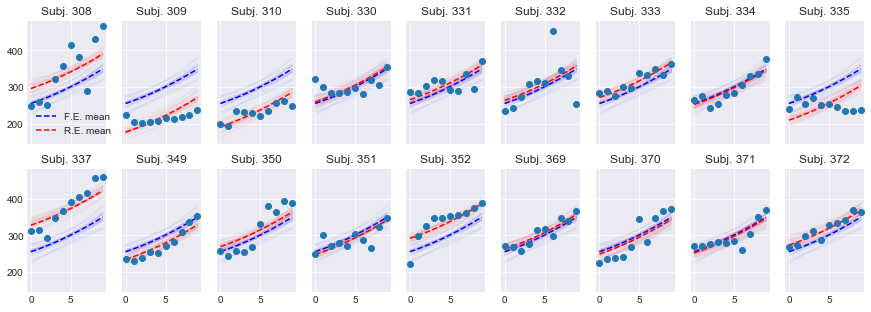

In [33]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    for b0, b1, b2 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500], 
                      trace_df['beta_X_slope_pow2'][::500]):
        ax[i].plot(days, b0 + days*b1 + (days**2)*b2, '-b', alpha=0.05)
        ax[i].set_title('Subj. {}'.format(subject))

        
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, 
               trace_df['beta_X_intercept'].mean() + \
               days*trace_df['beta_X_slope'].mean() + \
               (days**2)*trace_df['beta_X_slope_pow2'].mean(), '--b',
              label='F.E. mean')
    
# Random effect
for i, subject in enumerate(subject_ids):
    for b0, b1 ,b2, g0 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500], 
                      trace_df['beta_X_slope_pow2'][::500],
                      trace_df['gamma_Z__{}'.format(i)][::500]):
        ax[i].plot(days, 
                   b0 + g0 + \
                   days * b1 + \
                   (days**2) * b2, '-r', alpha=0.05)

for i, subject in enumerate(subject_ids):
    ax[i].plot(days,
               trace_df['beta_X_intercept'].mean() + trace_df['gamma_Z__{}'.format(i)].mean() + 
               days * trace_df['beta_X_slope'].mean() + \
               (days**2) * trace_df['beta_X_slope_pow2'].mean(), '--r', 
               label='R.E. mean')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    

ax[0].legend();

100%|██████████| 250/250 [00:00<00:00, 363.13it/s]


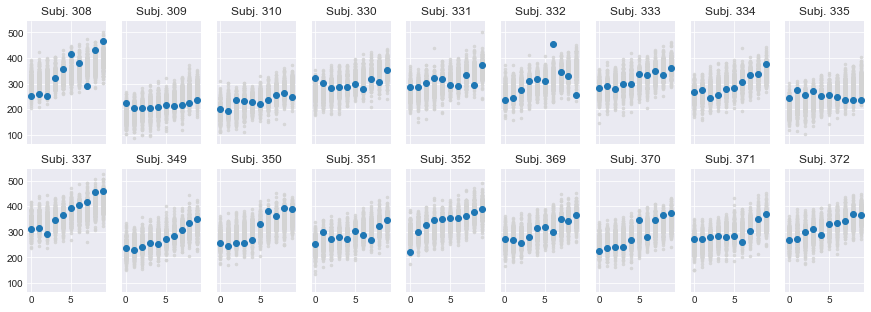

In [34]:
ppc = pm.sample_ppc(trace_intercept_pow2, samples=250, model=model_intercept_pow2)

days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, ppc['y_likelihood'].T[sleep.Subject==subject], marker='.', markersize=5, linestyle='none', alpha=0.8, color='lightgray')
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    ax[i].set_title('Subj. {}'.format(subject))

In [35]:
waic = pm.waic(trace_intercept_pow2, model_intercept_pow2, progressbar=True)
waic.WAIC

8000it [00:03, 2222.66it/s]
/Users/Alberto/miniconda3/envs/bayestest/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


1770.9015273855725

In [36]:
loo = pm.loo(trace_intercept_pow2, model_intercept_pow2)
loo.LOO

/Users/Alberto/miniconda3/envs/bayestest/lib/python3.6/site-packages/pymc3/stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


1771.3704125754502